In [0]:
%tensorflow_version 2.x

In [0]:
#匯入套件
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [3]:
#讀取資料集
(x_train, y_train0), (x_test, y_test0) = datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#reshape size
x_train = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

#標準化
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

### 建立VAE

In [0]:
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(128, activation='sigmoid')
enc_3 = Dense(64, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_0 = Dense(784, activation='sigmoid')
dec_1 = Dense(512, activation='sigmoid')
dec_2 = Dense(128, activation='sigmoid')
dec_3 = Dense(64, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_1_x = enc_1(x)
enc_2_x = enc_2(enc_1_x)
enc_3_x = enc_3(enc_2_x)

z_mean = enc_mean(enc_3_x)
z_log_var = enc_log_var(enc_3_x)

In [0]:
#定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon   

In [0]:
# Sampling function wrapped as a Keras layer

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_0(dec_1(dec_2(dec_3(z))))

In [9]:
#看模型summary
VAE = Model(x, x_hat)
VAE.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

### loss function

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

###開始訓練模型
####batch size = 200
####訓練20次

In [12]:
VAE.fit(x_train, x_train, batch_size=200, epochs=20)

Epoch 1/20
300/300 [==============================] - 8s 27ms/step - loss: 54.6473
Epoch 2/20
300/300 [==============================] - 8s 27ms/step - loss: 52.8912
Epoch 3/20
300/300 [==============================] - 8s 27ms/step - loss: 52.8747
Epoch 4/20
300/300 [==============================] - 8s 27ms/step - loss: 52.8623
Epoch 5/20
300/300 [==============================] - 8s 26ms/step - loss: 49.4606
Epoch 6/20
300/300 [==============================] - 8s 27ms/step - loss: 47.5918
Epoch 7/20
300/300 [==============================] - 8s 27ms/step - loss: 46.4732
Epoch 8/20
300/300 [==============================] - 8s 27ms/step - loss: 45.5673
Epoch 9/20
300/300 [==============================] - 8s 27ms/step - loss: 44.6516
Epoch 10/20
300/300 [==============================] - 8s 27ms/step - loss: 43.7906
Epoch 11/20
300/300 [==============================] - 8s 27ms/step - loss: 43.1727
Epoch 12/20
300/300 [==============================] - 8s 27ms/step - loss: 42.7163
E

###視覺化

In [13]:
VAE_Encoder = Model(x, z)
VAE_Encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

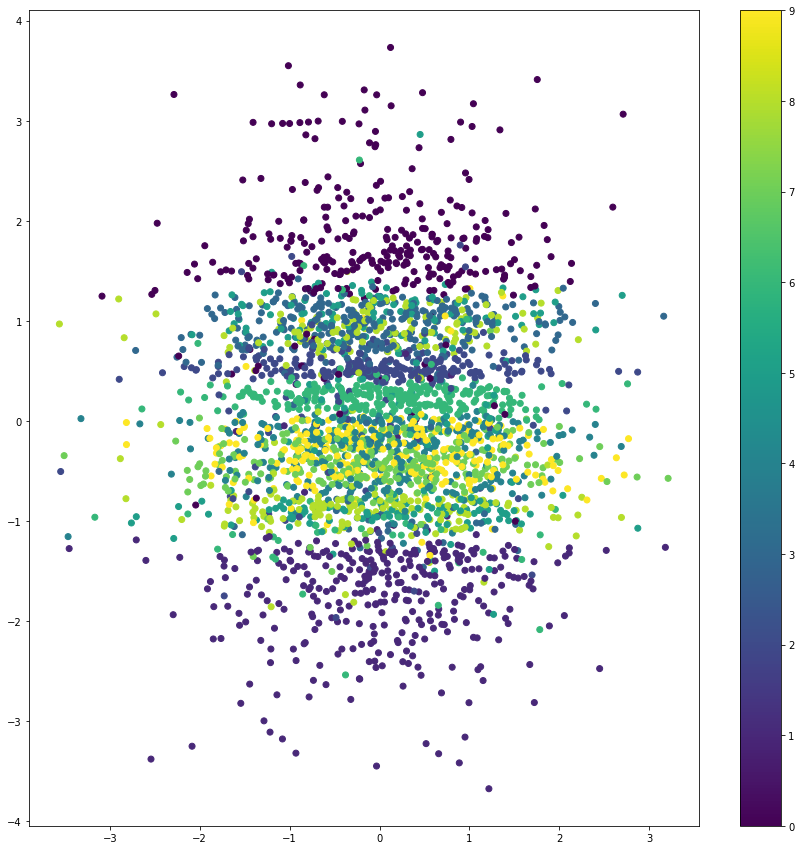

In [15]:
plt.figure(figsize=(15, 15))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='viridis')
plt.colorbar()
plt.show()

### Decoder

In [18]:
VAE_Decoder = Model(z_input, dec_0(dec_1(dec_2(dec_3(z_input)))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 476,752
Trainable params: 476,752
Non-trainable params: 0
_________________________________________________________________


In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15  #每排有多少點
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

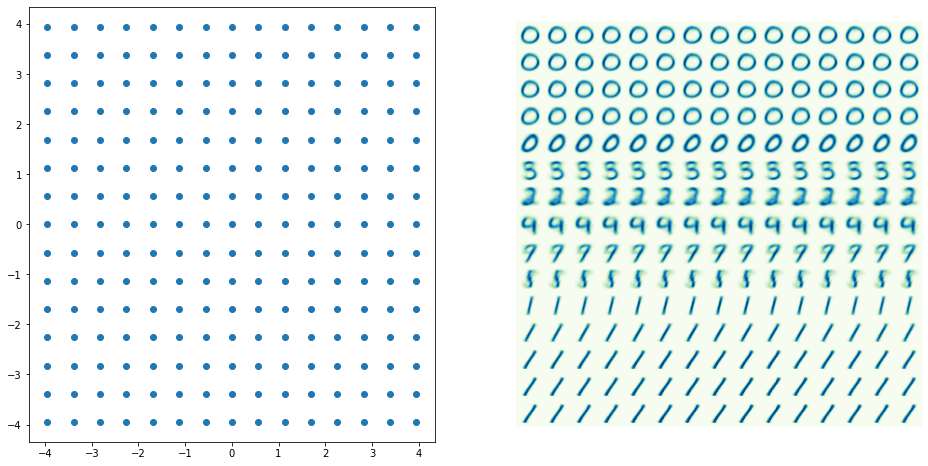

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='GnBu')
plt.axis('off')
plt.show()